### GTSRB Traffic Sign Recognition - Part III

### CODE ONLY, For a detailed report, please refer to the GTSRB Final Report Part III

#### by Sean Sungil Kim

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# importing necessary modules
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time
import warnings
warnings.filterwarnings("ignore")

# custom python scripts
import GTSRB_sungil           # preprocessing
import ConvNet_sungil         # ConvNet modeling

Using TensorFlow backend.


### Preprocessing

In [3]:
# reading the GTSRB data utilizing the custom python script
# grayscaled
num_classes = 43
data_GTSRB, data_class, labels = GTSRB_sungil.load_data(num_classes)
gray_GTSRB = GTSRB_sungil.gray_convrt(data_GTSRB)

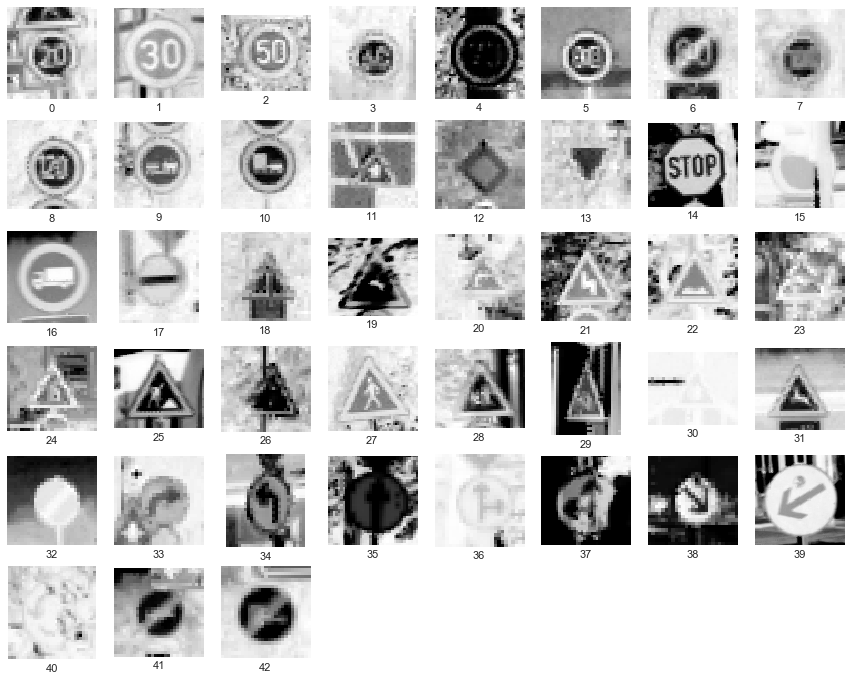

In [4]:
# one image example from each class, pre grayscale and downsizing
plt.figure(figsize = (15, 12))
for i in range(num_classes):
    plt.subplot(6, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(gray_GTSRB[data_class.tolist().index([i])], cmap = plt.cm.binary)
    plt.xlabel(i)
plt.show()

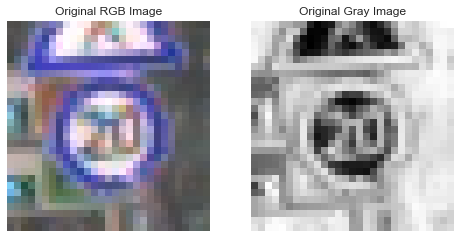

In [5]:
# original and post grayscale comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.show()

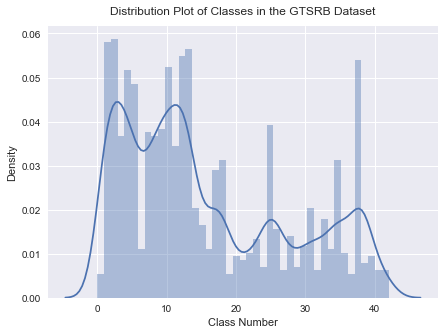

Total 39209 images in the GTSRB dataset
Total 39209 classes in the GTSRB class


In [6]:
# original class distribution
fig = plt.figure(figsize = (7, 5))
sns.distplot(data_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the GTSRB Dataset', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

# length of the data
print('Total %i images in the GTSRB dataset' % len(data_GTSRB))
print('Total %i classes in the GTSRB class' % len(data_class))

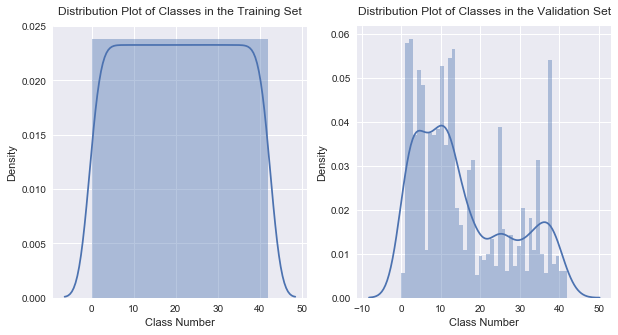

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [7]:
# resizing
resize_data = GTSRB_sungil.resize_all(gray_GTSRB, size = (28, 28))

# normalizing data, RGB/grayscale images are out of 255
norm_resized = resize_data / 255.0

# reshaping to be suitable for keras and tensorflow
nn_reshaped = GTSRB_sungil.nn_reshape(norm_resized)

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
x_train, x_val, y_class, y_val = train_test_split(nn_reshaped, data_class,\
                                                  stratify = data_class, test_size = 0.055)

# random under-sampling
und_train, und_class = GTSRB_sungil.under_sample(x_train, y_class)

# converting a class vector to binary class matrix
y_class_bin = keras.utils.to_categorical(und_class, num_classes)
y_val_bin = keras.utils.to_categorical(y_val, num_classes)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_train) + len(x_val)
print('Total of %i images in the training data' % len(und_train))
print('Total of %i images in the validation data' % len(x_val))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_train)/tot_len*100, len(x_val)/tot_len*100))

### Exploring with ConvNet Architectures

#### Small (Conv-Pool-Dropout)

In [8]:
model1 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

lr_finder1 = ConvNet_sungil.lr_finder(model1)
lr_finder1.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 30s 4ms/step - loss: 3.6887 - acc: 0.0519
Epoch 2/10
8514/8514 [==============================] - 20s 2ms/step - loss: 3.2635 - acc: 0.1829
Epoch 3/10
8514/8514 [==============================] - 20s 2ms/step - loss: 2.1760 - acc: 0.4450
Epoch 4/10
8514/8514 [==============================] - 27s 3ms/step - loss: 1.1148 - acc: 0.7055
Epoch 5/10
8514/8514 [==============================] - 22s 3ms/step - loss: 0.7746 - acc: 0.7934
Epoch 6/10
7808/8514 [==========================>...] - ETA: 1s - loss: 1.1471 - acc: 0.7002

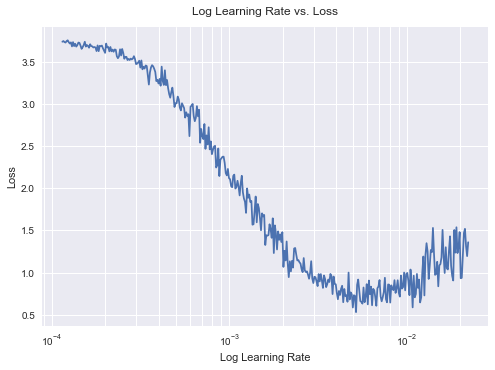

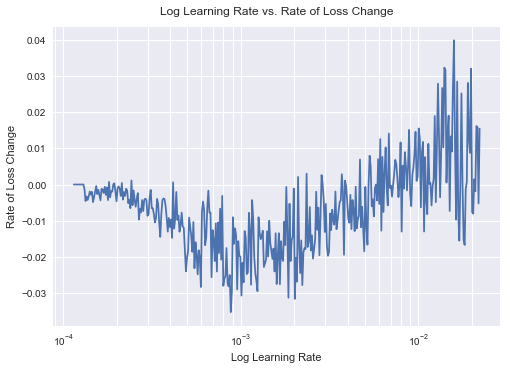

In [9]:
lr_finder1.plot_loss()
lr_finder1.plot_loss_change(sma = 20)

In [10]:
K.set_value(model1.optimizer.lr, 5*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model1.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history1 = model1.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 25s 3ms/step - loss: 2.9369 - acc: 0.2287 - val_loss: 1.5199 - val_acc: 0.6240

Epoch 00001: val_acc improved from -inf to 0.62401, saving model to best_model1.h5
Epoch 2/200
8514/8514 [==============================] - 21s 2ms/step - loss: 1.1755 - acc: 0.6690 - val_loss: 0.7294 - val_acc: 0.8122

Epoch 00002: val_acc improved from 0.62401 to 0.81224, saving model to best_model1.h5
Epoch 3/200
8514/8514 [==============================] - 20s 2ms/step - loss: 0.6730 - acc: 0.8075 - val_loss: 0.5481 - val_acc: 0.8572

Epoch 00003: val_acc improved from 0.81224 to 0.85721, saving model to best_model1.h5
Epoch 4/200
8514/8514 [==============================] - 25s 3ms/step - loss: 0.5393 - acc: 0.8451 - val_loss: 0.4469 - val_acc: 0.8697

Epoch 00004: val_acc improved from 0.85721 to 0.86973, saving model to best_model1.h5
Epoch 5/200
8514/8514 [==============================] - 26s 3m

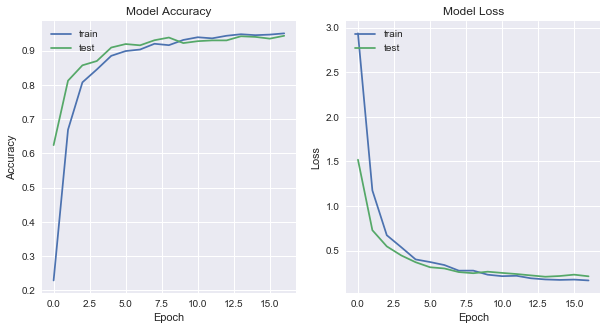

In [11]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['acc']), plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss']), plt.plot(history1.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Conv-Pool-Dropout)

In [12]:
model2 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder2 = ConvNet_sungil.lr_finder(model2)
lr_finder2.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 46s 5ms/step - loss: 3.6935 - acc: 0.0526
Epoch 2/10
8514/8514 [==============================] - 42s 5ms/step - loss: 2.9003 - acc: 0.2848
Epoch 3/10
8514/8514 [==============================] - 41s 5ms/step - loss: 1.2847 - acc: 0.6533
Epoch 4/10
8514/8514 [==============================] - 37s 4ms/step - loss: 0.6607 - acc: 0.8128
Epoch 5/10
8514/8514 [==============================] - 37s 4ms/step - loss: 0.5373 - acc: 0.8451
Epoch 6/10
7424/8514 [=========================>....] - ETA: 5s - loss: 0.6354 - acc: 0.8252

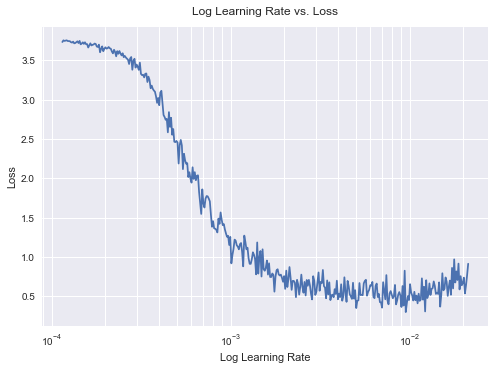

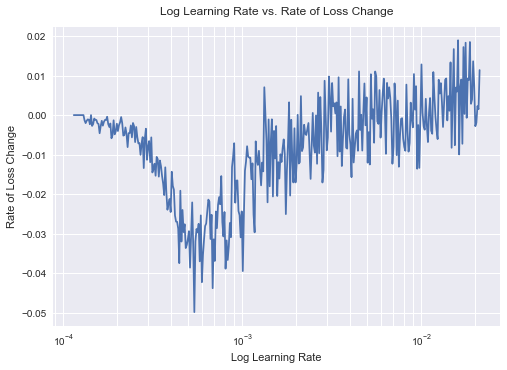

In [13]:
lr_finder2.plot_loss()
lr_finder2.plot_loss_change(sma = 20)

In [14]:
K.set_value(model2.optimizer.lr, 2*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model2.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history2 = model2.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 49s 6ms/step - loss: 3.2371 - acc: 0.1695 - val_loss: 1.8569 - val_acc: 0.5637

Epoch 00001: val_acc improved from -inf to 0.56375, saving model to best_model2.h5
Epoch 2/200
8514/8514 [==============================] - 42s 5ms/step - loss: 1.1888 - acc: 0.6650 - val_loss: 0.6951 - val_acc: 0.8155

Epoch 00002: val_acc improved from 0.56375 to 0.81548, saving model to best_model2.h5
Epoch 3/200
8514/8514 [==============================] - 44s 5ms/step - loss: 0.5406 - acc: 0.8501 - val_loss: 0.3499 - val_acc: 0.9147

Epoch 00003: val_acc improved from 0.81548 to 0.91470, saving model to best_model2.h5
Epoch 4/200
8514/8514 [==============================] - 47s 5ms/step - loss: 0.3300 - acc: 0.9059 - val_loss: 0.2579 - val_acc: 0.9434

Epoch 00004: val_acc improved from 0.91470 to 0.94344, saving model to best_model2.h5
Epoch 5/200
8514/8514 [==============================] - 49s 6m

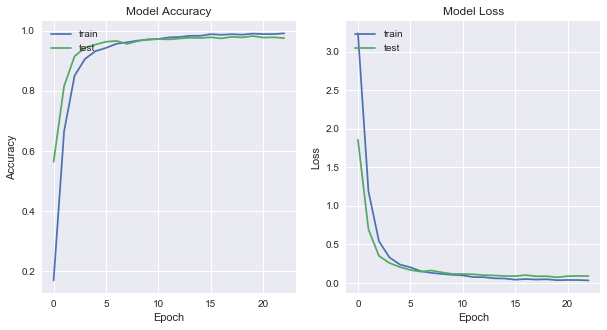

In [15]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['acc']), plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss']), plt.plot(history2.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Pool-Conv-Pool-Dropout)

In [16]:
model3 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder3 = ConvNet_sungil.lr_finder(model3)
lr_finder3.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 15s 2ms/step - loss: 3.7425 - acc: 0.0311
Epoch 2/10
8514/8514 [==============================] - 16s 2ms/step - loss: 3.5439 - acc: 0.1103
Epoch 3/10
8514/8514 [==============================] - 19s 2ms/step - loss: 2.3040 - acc: 0.3946
Epoch 4/10
8514/8514 [==============================] - 19s 2ms/step - loss: 1.1452 - acc: 0.6702
Epoch 5/10
8514/8514 [==============================] - 18s 2ms/step - loss: 0.7592 - acc: 0.7743
Epoch 6/10
8514/8514 [==============================] - 18s 2ms/step - loss: 0.8362 - acc: 0.7580
Epoch 7/10
1664/8514 [====>.........................] - ETA: 14s - loss: 1.3341 - acc: 0.6442

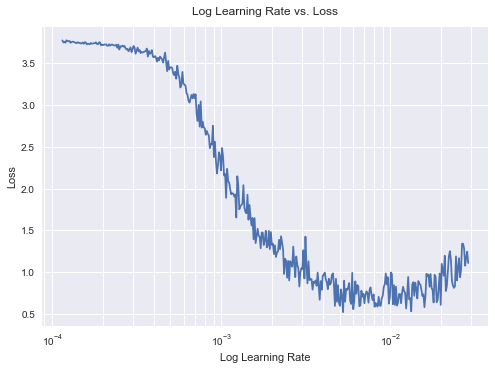

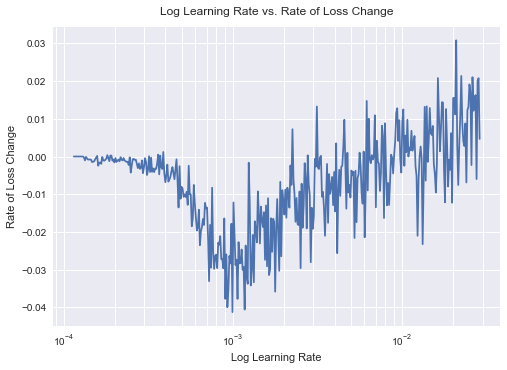

In [17]:
lr_finder3.plot_loss()
lr_finder3.plot_loss_change(sma = 20)

In [18]:
K.set_value(model3.optimizer.lr, 4*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model3.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history3 = model3.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 19s 2ms/step - loss: 3.2923 - acc: 0.1341 - val_loss: 2.3767 - val_acc: 0.3681

Epoch 00001: val_acc improved from -inf to 0.36810, saving model to best_model3.h5
Epoch 2/200
8514/8514 [==============================] - 16s 2ms/step - loss: 1.6981 - acc: 0.5036 - val_loss: 1.0304 - val_acc: 0.7038

Epoch 00002: val_acc improved from 0.36810 to 0.70376, saving model to best_model3.h5
Epoch 3/200
8514/8514 [==============================] - 17s 2ms/step - loss: 0.8228 - acc: 0.7571 - val_loss: 0.4898 - val_acc: 0.8637

Epoch 00003: val_acc improved from 0.70376 to 0.86370, saving model to best_model3.h5
Epoch 4/200
8514/8514 [==============================] - 15s 2ms/step - loss: 0.5186 - acc: 0.8397 - val_loss: 0.3698 - val_acc: 0.8957

Epoch 00004: val_acc improved from 0.86370 to 0.89569, saving model to best_model3.h5
Epoch 5/200
8514/8514 [==============================] - 16s 2m

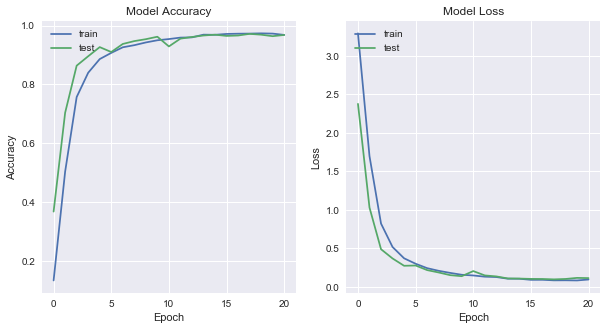

In [19]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['acc']), plt.plot(history3.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss']), plt.plot(history3.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Conv-Pool-Conv-Conv-Pool-Dropout)

In [20]:
model4 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder4 = ConvNet_sungil.lr_finder(model4)
lr_finder4.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 41s 5ms/step - loss: 3.7477 - acc: 0.0319
Epoch 2/10
8514/8514 [==============================] - 35s 4ms/step - loss: 3.1339 - acc: 0.2070
Epoch 3/10
8514/8514 [==============================] - 43s 5ms/step - loss: 1.4936 - acc: 0.5829
Epoch 4/10
8514/8514 [==============================] - 35s 4ms/step - loss: 0.7595 - acc: 0.7812
Epoch 5/10
8514/8514 [==============================] - 45s 5ms/step - loss: 0.5255 - acc: 0.8430
Epoch 6/10
5504/8514 [==================>...........] - ETA: 12s - loss: 0.6667 - acc: 0.8072

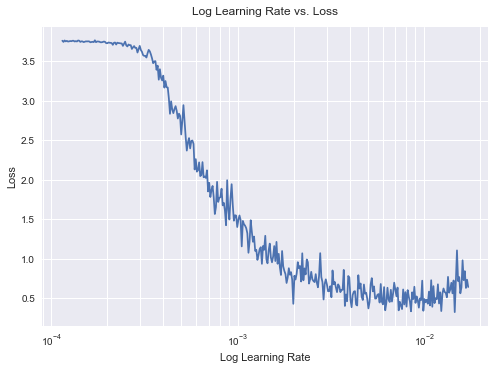

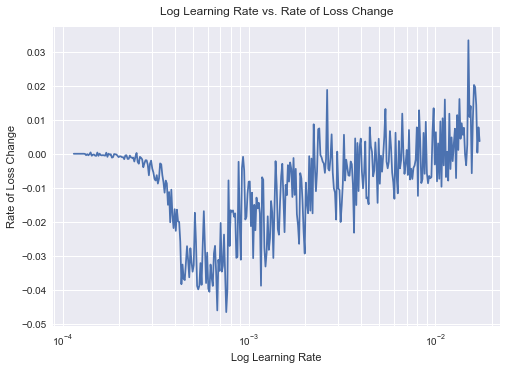

In [21]:
lr_finder4.plot_loss()
lr_finder4.plot_loss_change(sma = 20)

In [22]:
K.set_value(model4.optimizer.lr, 2*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model4.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history4 = model4.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 43s 5ms/step - loss: 3.7130 - acc: 0.0432 - val_loss: 3.5695 - val_acc: 0.1011

Epoch 00001: val_acc improved from -inf to 0.10107, saving model to best_model4.h5
Epoch 2/200
8514/8514 [==============================] - 39s 5ms/step - loss: 2.4007 - acc: 0.3661 - val_loss: 1.3033 - val_acc: 0.6338

Epoch 00002: val_acc improved from 0.10107 to 0.63375, saving model to best_model4.h5
Epoch 3/200
8514/8514 [==============================] - 43s 5ms/step - loss: 1.0359 - acc: 0.7071 - val_loss: 0.6252 - val_acc: 0.8345

Epoch 00003: val_acc improved from 0.63375 to 0.83449, saving model to best_model4.h5
Epoch 4/200
8514/8514 [==============================] - 39s 5ms/step - loss: 0.5788 - acc: 0.8306 - val_loss: 0.3432 - val_acc: 0.9115

Epoch 00004: val_acc improved from 0.83449 to 0.91145, saving model to best_model4.h5
Epoch 5/200
8514/8514 [==============================] - 38s 4m

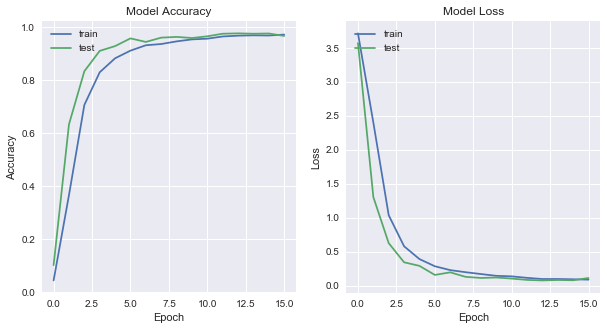

In [23]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['acc']), plt.plot(history4.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss']), plt.plot(history4.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium-Large (Conv-Pool-Conv-Pool-Conv-Pool-Dropout)

In [24]:
model5 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model5.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder5 = ConvNet_sungil.lr_finder(model5)
lr_finder5.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 14s 2ms/step - loss: 3.7598 - acc: 0.0236
Epoch 2/10
8514/8514 [==============================] - 13s 2ms/step - loss: 3.7376 - acc: 0.0284: 2s - loss: 3.7434 - 
Epoch 3/10
8514/8514 [==============================] - 14s 2ms/step - loss: 3.4910 - acc: 0.0887: 0s - loss: 3.5155 - acc: 0
Epoch 4/10
8514/8514 [==============================] - 14s 2ms/step - loss: 2.5479 - acc: 0.2730: 0s - loss: 2.5674 - acc: 0.2
Epoch 5/10
8514/8514 [==============================] - 13s 2ms/step - loss: 1.7794 - acc: 0.4616
Epoch 6/10
8514/8514 [==============================] - 13s 2ms/step - loss: 1.6613 - acc: 0.5039: 9s - loss: 1.4806 - acc: - ETA: 0s - loss: 1.6528 - acc: 0.5
Epoch 7/10
6016/8514 [====================>.........] - ETA: 3s - loss: 2.4935 - acc: 0.3575

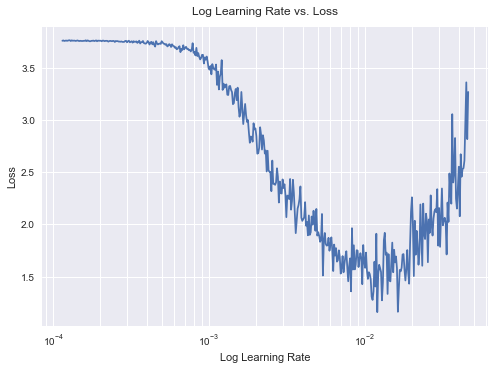

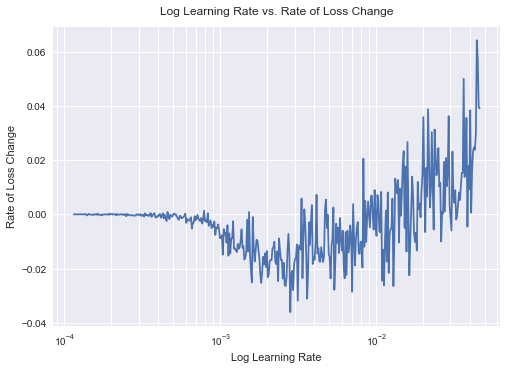

In [25]:
lr_finder5.plot_loss()
lr_finder5.plot_loss_change(sma = 20)

In [26]:
K.set_value(model5.optimizer.lr, 8*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model5.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history5 = model5.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 17s 2ms/step - loss: 3.7470 - acc: 0.0294 - val_loss: 3.6859 - val_acc: 0.0431

Epoch 00001: val_acc improved from -inf to 0.04312, saving model to best_model5.h5
Epoch 2/200
8514/8514 [==============================] - 13s 2ms/step - loss: 3.6453 - acc: 0.0432 - val_loss: 3.5279 - val_acc: 0.0709

Epoch 00002: val_acc improved from 0.04312 to 0.07093, saving model to best_model5.h5
Epoch 3/200
8514/8514 [==============================] - 13s 2ms/step - loss: 3.2763 - acc: 0.0893 - val_loss: 3.1371 - val_acc: 0.1154

Epoch 00003: val_acc improved from 0.07093 to 0.11544, saving model to best_model5.h5
Epoch 4/200
8514/8514 [==============================] - 14s 2ms/step - loss: 2.6515 - acc: 0.2104 - val_loss: 2.0095 - val_acc: 0.3885

Epoch 00004: val_acc improved from 0.11544 to 0.38850, saving model to best_model5.h5
Epoch 5/200
8514/8514 [==============================] - 15s 2m

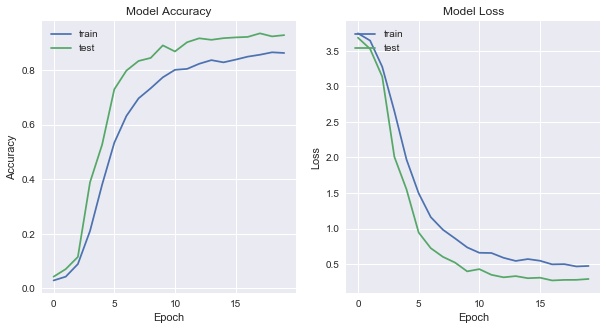

In [27]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history5.history['acc']), plt.plot(history5.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss']), plt.plot(history5.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium-Large (Conv-Pool-Conv-Conv-Pool-Conv-Pool-Dropout)

In [28]:
model6 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model6.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder6 = ConvNet_sungil.lr_finder(model6)
lr_finder6.find(und_train, y_class_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
8514/8514 [==============================] - 21s 2ms/step - loss: 3.7587 - acc: 0.0227
Epoch 2/10
8514/8514 [==============================] - 17s 2ms/step - loss: 3.7343 - acc: 0.0312
Epoch 3/10
8514/8514 [==============================] - 16s 2ms/step - loss: 3.3991 - acc: 0.1128
Epoch 4/10
8514/8514 [==============================] - 17s 2ms/step - loss: 2.3015 - acc: 0.3356
Epoch 5/10
8514/8514 [==============================] - 20s 2ms/step - loss: 1.6232 - acc: 0.5059
Epoch 6/10
8320/8514 [============================>.] - ETA: 0s - loss: 1.6520 - acc: 0.5269

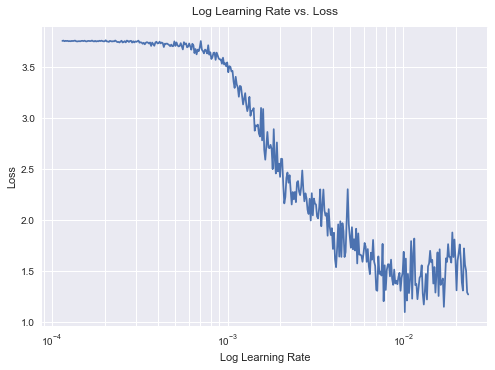

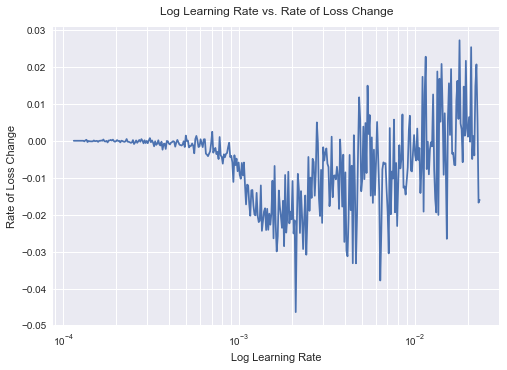

In [29]:
lr_finder6.plot_loss()
lr_finder6.plot_loss_change(sma = 20)

In [30]:
K.set_value(model6.optimizer.lr, 4*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model6.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history6 = model6.fit(und_train, y_class_bin, batch_size = 128, epochs = 200,\
                      validation_data = (x_val, y_val_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/200
8514/8514 [==============================] - 22s 3ms/step - loss: 3.7572 - acc: 0.0253 - val_loss: 3.7508 - val_acc: 0.0496

Epoch 00001: val_acc improved from -inf to 0.04961, saving model to best_model6.h5
Epoch 2/200
8514/8514 [==============================] - 17s 2ms/step - loss: 3.7255 - acc: 0.0370 - val_loss: 3.6738 - val_acc: 0.0297

Epoch 00002: val_acc did not improve from 0.04961
Epoch 3/200
8514/8514 [==============================] - 17s 2ms/step - loss: 3.6426 - acc: 0.0530 - val_loss: 3.5057 - val_acc: 0.0635

Epoch 00003: val_acc improved from 0.04961 to 0.06351, saving model to best_model6.h5
Epoch 4/200
8514/8514 [==============================] - 16s 2ms/step - loss: 3.1971 - acc: 0.1268 - val_loss: 2.6056 - val_acc: 0.2582

Epoch 00004: val_acc improved from 0.06351 to 0.25823, saving model to best_model6.h5
Epoch 5/200
8514/8514 [==============================] - 16s 2ms/step - loss: 2.4385 - acc: 0.2900 

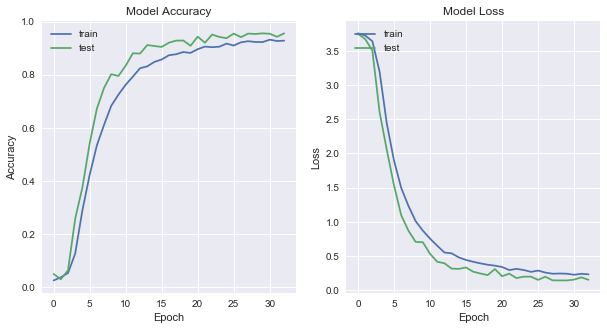

In [31]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['acc']), plt.plot(history6.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss']), plt.plot(history6.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Model Performance Comparisons

In [32]:
# model performance scores
saved_model1 = keras.models.load_model('best_model1.h5')
saved_model2 = keras.models.load_model('best_model2.h5')
saved_model3 = keras.models.load_model('best_model3.h5')
saved_model4 = keras.models.load_model('best_model4.h5')
saved_model5 = keras.models.load_model('best_model5.h5')
saved_model6 = keras.models.load_model('best_model6.h5')

y_prob1 = saved_model1.predict(x_val)
y_prob2 = saved_model2.predict(x_val)
y_prob3 = saved_model3.predict(x_val)
y_prob4 = saved_model4.predict(x_val)
y_prob5 = saved_model5.predict(x_val)
y_prob6 = saved_model6.predict(x_val)

cls_pred1 = y_prob1.argmax(axis = -1)
cls_pred2 = y_prob2.argmax(axis = -1)
cls_pred3 = y_prob3.argmax(axis = -1)
cls_pred4 = y_prob4.argmax(axis = -1)
cls_pred5 = y_prob5.argmax(axis = -1)
cls_pred6 = y_prob6.argmax(axis = -1)

precision1, recall1, fbeta_score1, support1 = precision_recall_fscore_support(y_val, cls_pred1, average = 'weighted')
precision2, recall2, fbeta_score2, support2 = precision_recall_fscore_support(y_val, cls_pred2, average = 'weighted')
precision3, recall3, fbeta_score3, support3 = precision_recall_fscore_support(y_val, cls_pred3, average = 'weighted')
precision4, recall4, fbeta_score4, support4 = precision_recall_fscore_support(y_val, cls_pred4, average = 'weighted')
precision5, recall5, fbeta_score5, support5 = precision_recall_fscore_support(y_val, cls_pred5, average = 'weighted')
precision6, recall6, fbeta_score6, support6 = precision_recall_fscore_support(y_val, cls_pred6, average = 'weighted')

model_List = ['model1', 'model2', 'model3', 'model4', 'model5', 'model6']
precision_List = [precision1, precision2, precision3, precision4, precision5, precision6]
recall_List = [recall1, recall2, recall3, recall4, recall5, recall6]
fscore_List = [fbeta_score1, fbeta_score2, fbeta_score3, fbeta_score4, fbeta_score5, fbeta_score6]

In [33]:
# final results table
final_results = pd.DataFrame({'Models': model_List, 'Precision Score': precision_List,\
                              'Recall Score': recall_List, 'F-Score': fscore_List}).set_index('Models')
final_results

,Precision Score,Recall Score,F-Score
Models,,,
model1,0.948569,0.943440,0.944362
model2,0.982360,0.981919,0.981933
model3,0.972871,0.971720,0.971749
model4,0.978476,0.977747,0.977728
model5,0.941015,0.933704,0.934787
model6,0.958390,0.955957,0.955908


### Final CNN Model

CNN classification report: 

               precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.97      0.94      0.95       122
           2       0.94      0.95      0.95       124
           3       0.97      0.99      0.98        78
           4       0.98      1.00      0.99       109
           5       0.97      0.96      0.97       102
           6       1.00      1.00      1.00        23
           7       1.00      0.95      0.97        79
           8       1.00      0.97      0.99        78
           9       0.96      0.99      0.98        81
          10       1.00      0.98      0.99       111
          11       0.99      0.99      0.99        73
          12       1.00      0.99      1.00       115
          13       1.00      0.98      0.99       119
          14       1.00      1.00      1.00        43
          15       1.00      1.00      1.00        35
          16       1.00      1.00      1.00        

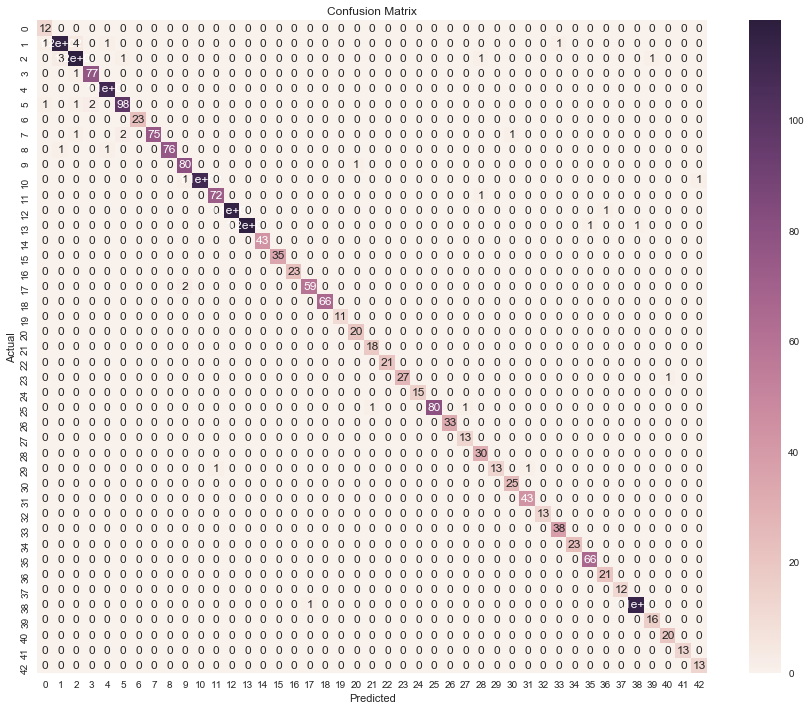

In [34]:
# classification report
print("CNN classification report:", "\n\n", classification_report(y_val, cls_pred2))

# accuracy confusion matrix
cm = confusion_matrix(y_val, cls_pred2)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

### Final 3 Models

| Classifiers | Precision | Recall | F-Score |
| --- | --- | --- | --- |
| CNN with the Architecture of Conv-Pool-Conv-Pool-Dropout (model3) | 0.982360 | 0.981919 | 0.981933 |
| Thresheld + Feature Selected (Wrapper-based) Random Forest Classifier from Part II | 0.924908 | 0.918869 | 0.918973 |
| Thresheld + Feature Selected (Wrapper-based) Support Vector Machine Classifier from Part II | 0.923204 | 0.919796 | 0.920249 |
